# YOLOv2 Implementation
Notebook contains parts and peieces that builds up the YOLOv2 algorithm.

In [1]:
import tensorflow as tf
import numpy as np
import re
import pandas as pd
import os
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import scipy
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import imutils

In [2]:
# Enable eager execution in tensorflow
tf.enable_eager_execution()

## Utility Functions

In [3]:
def tf_cvt_coord_to_mid_point(coordinates):
    """
    Converts bounding boxes from corner coordinates to
    mid point coordinates
    
    Args:
        coordinates: A tensor of shape (N,B,4)
    Returns:
        Tensor of shape (N,B,4)
    """
    #Get mid points xc and yc
    # xc = (x1 + x2) / 2
    xc = (coordinates[:,:,0] + coordinates[:,:,2]) / 2.0
    # yc = (y1 + y2) / 2
    yc = (coordinates[:,:,1] + coordinates[:,:,3]) / 2.0
    
    #Get dimensions of the box
    # w = |x1 - x2|
    w = tf.abs(coordinates[:,:,0] - coordinates[:,:,2])
    # h = |y1 - y2|
    h = tf.abs(coordinates[:,:,1] - coordinates[:,:,3])
    
    #Add 2nd dimension to xc, yc, w, h tensor
    xc = tf.expand_dims(xc,axis=2)
    yc = tf.expand_dims(yc,axis=2)
    w = tf.expand_dims(w,axis=2)
    h = tf.expand_dims(h,axis=2)
    #Return concatenated tensor (xc,yc,w,h)
    return tf.concat((xc,yc,w,h),axis=2)

In [4]:
def tf_cvt_coord_to_diagonal(coordinates):
    """
    Converts bounding boxes from mid point coordinates to
    corner coordinates
    
    Args:
        coordinates: A tensor of shape (N,B,4)
    Returns:
        Tensor of shape (N,B,4)
    """
    # xmin = xc - w/2
    xmin = coordinates[:,:,0] - coordinates[:,:,2]/2.0
    #xmax = xc + w/2
    xmax = coordinates[:,:,0] + coordinates[:,:,2]/2.0
    #ymin = yc - w/2
    ymin = coordinates[:,:,1] - coordinates[:,:,3]/2.0
    #ymax = yc + w/2
    ymax = coordinates[:,:,1] + coordinates[:,:,3]/2.0
    
    #add 2nd dimensions to all above tensors
    xmin = tf.expand_dims(xmin,axis=2)
    xmax = tf.expand_dims(xmax,axis=2)
    ymin = tf.expand_dims(ymin,axis=2)
    ymax = tf.expand_dims(ymax,axis=2)
    #return concatenated tensor of (xmin,ymin,xmax,ymax)
    return tf.concat((xmin,ymin,xmax,ymax),axis=2)

In [5]:
def tf_intersection_over_union(boxA, boxB):
    """
    Finds the intersection over union between boxes boxA and boxB.
    Coordinates must be in corner coordinate form. 
    
    Args:
        boxA: A tensor of shape (N,B,4)
        boxB: A tensor of shape (N,B,4)
    Returns:
        Tensor of shape (N, B) containing IOU values. 
    """
    #Find coordinates of region of intersection (xA,yA, xB,yB)
    #xA = max(boxA[xmin], boxB[xmin])
    xA = tf.maximum(boxA[:,:,0], boxB[:,:,0])
    #yA = max(boxA[ymin], boxB[ymin])
    yA = tf.maximum(boxA[:,:,1], boxB[:,:,1])
    #xB = max(boxA[xmax], boxB[xmax])
    xB = tf.minimum(boxA[:,:,2], boxB[:,:,2])
    #yB = max(boxA[ymax], boxB[ymax])
    yB = tf.minimum(boxA[:,:,3], boxB[:,:,3])
    
    #find area of intersection. If there is not intersection then xB - xA or
    #yB - yA is -ve. Hence interArea will be zero
    interArea = tf.maximum(0, xB - xA ) * tf.maximum(0, yB - yA )
    #Find area of box A = (x2 - x1)*(y2 - y1)
    boxAArea = (boxA[:,:,2] - boxA[:,:,0] ) * (boxA[:,:,3] - boxA[:,:,1] )
    #Find area of box B = (x2 - x1)*(y2 - y1)
    boxBArea = (boxB[:,:,2] - boxB[:,:,0]) * (boxB[:,:,3] - boxB[:,:,1])
    #Find iou = areaOfIntersection / (areOfBoxA + areaOfBox - areaOfIntersection)
    iou = interArea / (boxAArea + boxBArea - interArea)
    return iou

In [6]:
def np_cvt_coord_to_mid_point(coordinates):
    """
    Converts bounding boxes from corner coordinates to
    mid point coordinates
    
    Args:
        coordinates: A tensor of shape (N,B,4)
    Returns:
        Tensor of shape (N,B,4)
    """
    #Get mid points xc and yc
    # xc = (x1 + x2) / 2
    xc = (coordinates[:,:,0] + coordinates[:,:,2]) / 2.0
    # yc = (y1 + y2) / 2
    yc = (coordinates[:,:,1] + coordinates[:,:,3]) / 2.0
    #Get dimensions of the box
    # w = |x1 - x2|
    # h = |y1 - y2|
    w = np.abs(coordinates[:,:,0] - coordinates[:,:,2])
    h = np.abs(coordinates[:,:,1] - coordinates[:,:,3])
    
    #Add 2nd dimension to xc, yc, w, h tensor
    xc = np.expand_dims(xc,axis=2)
    yc = np.expand_dims(yc,axis=2)
    w = np.expand_dims(w,axis=2)
    h = np.expand_dims(h,axis=2)
    #Return concatenated tensor (xc,yc,w,h)
    return np.concatenate((xc,yc,w,h),axis=2)

In [7]:
x = np.array([ [1,1,5,5],
              [2,3,4,5]]).reshape(1,2,4)
np_cvt_coord_to_mid_point(x)

array([[[3., 3., 4., 4.],
        [3., 4., 2., 2.]]])

In [8]:
def np_cvt_coord_to_diagonal(coordinates):
    """
    Converts bounding boxes from mid point coordinates to
    corner coordinates
    
    Args:
        coordinates: A tensor of shape (N,B,4)
    Returns:
        Tensor of shape (N,B,4)
    """
    # xmin = xc - w/2
    #xmax = xc + w/2
    #ymin = yc - w/2
    #ymax = yc + w/2
    #add 2nd dimensions to all above tensors
    #return concatenated tensor of (xmin,ymin,xmax,ymax)

    xmin = coordinates[:,:,0] - coordinates[:,:,2]/2.0
    xmax = coordinates[:,:,0] + coordinates[:,:,2]/2.0
    ymin = coordinates[:,:,1] - coordinates[:,:,3]/2.0
    ymax = coordinates[:,:,1] + coordinates[:,:,3]/2.0
    xmin = np.expand_dims(xmin,axis=2)
    xmax = np.expand_dims(xmax,axis=2)
    ymin = np.expand_dims(ymin,axis=2)
    ymax = np.expand_dims(ymax,axis=2)
    return np.concatenate((xmin,ymin,xmax,ymax),axis=2)

In [9]:
x = [[3., 3., 4., 4.],
        [3., 4., 2., 2.]]
x = np.array(x).reshape(1,2,4)
np_cvt_coord_to_diagonal(x)

array([[[1., 1., 5., 5.],
        [2., 3., 4., 5.]]])

In [10]:
def np_intersection_over_union(boxA, boxB):
    """
    Finds the intersection over union between boxes boxA and boxB.
    Coordinates must be in corner coordinate form. 
    
    Args:
        boxA: A tensor of shape (N,B,4)
        boxB: A tensor of shape (N,B,4)
    Returns:
        Tensor of shape (N, B) containing IOU values. 
    """
    #Find coordinates of region of intersection (xA,yA, xB,yB)
    #xA = max(boxA[xmin], boxB[xmin])

    #yA = max(boxA[ymin], boxB[ymin])

    #xB = max(boxA[xmax], boxB[xmax])

    #yB = max(boxA[ymax], boxB[ymax])

    #find area of intersection. If there is not intersection then xB - xA or
    #yB - yA is -ve. Hence interArea will be zero

    #Find area of box A = (x2 - x1)*(y2 - y1)

    #Find area of box B = (x2 - x1)*(y2 - y1)

    #Find iou = areaOfIntersection / (areOfBoxA + areaOfBox - areaOfIntersection)

    xA = np.maximum(boxA[:,:,0], boxB[:,:,0])
    yA = np.maximum(boxA[:,:,1], boxB[:,:,1])
    xB = np.minimum(boxA[:,:,2], boxB[:,:,2])
    yB = np.minimum(boxA[:,:,3], boxB[:,:,3])
    interArea = np.maximum(0, xB - xA ) * np.maximum(0, yB - yA )
    boxAArea = (boxA[:,:,2] - boxA[:,:,0] ) * (boxA[:,:,3] - boxA[:,:,1] )
    boxBArea = (boxB[:,:,2] - boxB[:,:,0]) * (boxB[:,:,3] - boxB[:,:,1])
    iou = interArea / (boxAArea + boxBArea - interArea)
    return iou

In [11]:
boxA = np.array(
    [
        [1,1,4,4],
        [2,2,5,5]
    ]
).reshape(-1,2,4)

boxB =  np.array(
    [
        [2,2,3,4],
        [2,2,5,5]
    ]
).reshape(-1,2,4)

np_intersection_over_union(boxA,boxB)

array([[0.22222222, 1.        ]])

In [12]:
class AnnotationFileNotFoundError(Exception):
    """
    Exception thrown when annotation while corresponding to an 
    image file is not found.
    """
    def __init__(self,file_name):
        super(Exception,self).__init__('Annotation file '+file_name+' not found')

In [13]:
def np_gen_anchors(fx,fy,dim):
    """
    Generate anchor boxes of the form [xc,yc,w,h]
    
    Args:
        fx: width of grid 
        fy: height of grid
        dim: list of coordinates of the form [xc,yc,w,h]
        
    Returns:
        Tensor of shape (fx, fy, n_anchors, 4)
    """
    #Generate row vector 0, 1,2, 3.....fx-1
    xc = np.linspace(0,fx,endpoint=False,num=fx).reshape(-1,fx)
    #Generate column vector 0,1,2,3....fy-1
    yc = np.linspace(0,fy,endpoint=False,num=fy).reshape(fy,-1)
    #Copy row vector along 0th dimension for fy times
    xc = np.tile(xc,(fy,1))
    #Copy column vector along 1st dimension for fx times
    yc = np.tile(yc,(1,fx))
    
    #Reshape dimensions of xc to (fx, fy, 1)
    #xc = 
    # 0 1 2....fx
    # 0 1 2....fx 
    # . 
    # .
    # 0 1 2....fx
    xc = xc.reshape(fx,fy,-1)
    #Reshape dimensions of yc to (fx, fy, 1)
    #yc = 
    # 0 0 0....0
    # 1 1 1....1 
    # 2 2 2....2
    # . . .    .
    # fy fy....fy
    yc = yc.reshape(fx,fy,-1) 
    #Compute x coordinate of center of grid cell
    xc = (xc+0.5) / fx
    #Compute y coordinate of center of grid cell
    yc = (yc+0.5) / fy
    #Concatenate each xc, yc. c is of shape (fx, fy, 2)
    c = np.concatenate((xc,yc),axis=2)
    #Add new 0th axis to c, new shape of c is (1,fx,fy,2)
    #0th dimension is for number of anchors
    c = np.expand_dims(c,axis=0)
    #Create numpy array of dimensions(width and height) of anchors. 
    #It's shape is (n_anchors,2)
    dim = np.array(dim).reshape(-1,2)
    #add two more dimensions. New shape of dim is (n_anchors,1,1,2)
    #Here 0th axis is used for number of anchors
    # 1st axis is used for x grid
    # 2nd axis is used for y grid
    # 3rd axis is for width,height
    dim = np.expand_dims(dim,axis=1)
    dim = np.expand_dims(dim,axis=2)
    
    #Copy the dim tensor along grid_size axes
    dim = np.tile(dim,(1,fx,fy,1))
    #Copy center coordinates along axis of number of anchors ie 0th axis
    c = np.tile(c,(dim.shape[0],1,1,1))
    #Now the shape of c and dim is (n_anchors,fx,fy,2)
    #Concatenate along 3rd axis. anchors shape will be (n_anchors,fx,fy,4)
    anchors = np.concatenate((c,dim),axis=3)
    #Swap axis as follows. The new shape of anchors is (fx,fy,n_anchors,4)
    anchors = np.transpose(anchors,(1,2,0,3))
    return anchors

In [14]:
np_gen_anchors(3,3,[1.4,1.2])

array([[[[0.16666667, 0.16666667, 1.4       , 1.2       ]],

        [[0.5       , 0.16666667, 1.4       , 1.2       ]],

        [[0.83333333, 0.16666667, 1.4       , 1.2       ]]],


       [[[0.16666667, 0.5       , 1.4       , 1.2       ]],

        [[0.5       , 0.5       , 1.4       , 1.2       ]],

        [[0.83333333, 0.5       , 1.4       , 1.2       ]]],


       [[[0.16666667, 0.83333333, 1.4       , 1.2       ]],

        [[0.5       , 0.83333333, 1.4       , 1.2       ]],

        [[0.83333333, 0.83333333, 1.4       , 1.2       ]]]])

In [15]:
def tf_gen_anchors(fx,fy,dim):
    """
    Generate anchor boxes of the form [xc,yc,w,h]
    
    Args:
        fx: width of grid size
        fy: height of grid size
        dim: list of coordinates of the form [xc,yc,w,h]
        
    Returns:
        Tensor of shape (fx, fy, n_anchors, 4)
    """
    
    xc = tf.linspace(0.0,fx-1,num=fx)
    xc = tf.reshape(xc,(-1,fx))
    yc = tf.linspace(0.0,fy-1,num=fy)
    yc = tf.reshape(yc,(fy,-1))
    
    xc = tf.tile(xc,(fy,1))
    yc = tf.tile(yc,(1,fx))

    xc = tf.reshape(xc,(fx,fy,-1))
    yc = tf.reshape(yc,(fx,fy,-1)) 
    
    xc = (xc+0.5) / fx
    yc = (yc+0.5) / fy
    
    c = tf.concat((xc,yc),axis=2)
    c = tf.expand_dims(c,axis=0)
    

    dim = tf.convert_to_tensor(dim)
    dim = tf.cast(dim,dtype=tf.float32)
    dim = tf.reshape(dim,(-1,2))
    dim = tf.expand_dims(dim,axis=1)
    dim = tf.expand_dims(dim,axis=2)
    dim = tf.tile(dim,(1,fx,fy,1))

    c = tf.tile(c,(dim.shape[0],1,1,1))
    anchors = tf.concat((c,dim),axis=3)
    anchors = tf.transpose(anchors,(1,2,0,3))
    return anchors

## Data augmentation functions

In [17]:
def change_brightness(img, value):
    """
    Change the brightness of the image by some value
    
    Args:
        img: Image tensor
        value: Brightness to be reduced by this value. Negative or positive.
    Returns:
        Image with brightness changed. 
    
    """
    #Convert image from RGB space to HSV space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #Separate h, s and v components
    h, s, v = cv2.split(hsv)
    #We only change v component
    
    #If brightness is to be increased. value is +ve
    if value >=0:
        #lim is limiting intesity. Values above this intensity is set to 255
        #Values less than this intensity is simply increased
        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value
        
    #If brightness is to be decreased. value is -ve
    else:
        #Lim is limiting intensity. Intensities less than lim are set to 0
        #Intensities which are greater than lim are simply decreased.
        lim = -value
        v[v < lim] = 0
        v[v >= lim] -= -value
    
    #Combine h,s,v values
    final_hsv = cv2.merge((h, s, v))
    #Convert from hsv space to RGB space
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return img
    

In [18]:
def np_flip_boxes_about_xaxis(boxes,y_translate):
    """
    Flips bounding boxes along arbitrary xaxis
    Args:
        boxes: Tensor of shape(N,B,4) in corner coordinate format
        y_translate: distance of arbitrary xaxis from main xaxis
    Returns:
        flipped boxes as tensor of (N,B,4)
    """
#     boxes = boxes.astype(np.float32)
    boxes_mid_point = np_cvt_coord_to_mid_point(boxes).reshape(-1,4)
    coordinates = boxes_mid_point[:,0:2]
    
    translation = [0.0,y_translate]
    translation = np.array(translation).reshape(-1,2)
    
    translation = np.tile(translation,(coordinates.shape[0],1))
    flip = [
        [1, 0],
        [0,-1]
    ]
    flip = np.array(flip)
    coordinates = coordinates - translation
#     print(coordinates)
    coordinates = np.matmul(coordinates,flip)
    coordinates = coordinates+translation
    
    boxes_mid_point[:,0:2] = coordinates
    boxes_mid_point = boxes_mid_point.reshape(-1,boxes.shape[1],4)
    boxes = np_cvt_coord_to_diagonal(boxes_mid_point)
    return boxes

In [19]:
def np_flip_boxes_about_yaxis(boxes,x_translate):
    """
    Flips bounding boxes along arbitrary yaxis
    Args:
        boxes: Tensor of shape(N,B,4) in corner coordinate format
        x_translate: distance of arbitrary yaxis from main yaxis
    Returns:
        flipped boxes as tensor of (N,B,4)
    """
#     boxes = boxes.astype(np.float32)
    boxes_mid_point = np_cvt_coord_to_mid_point(boxes).reshape(-1,4)
    coordinates = boxes_mid_point[:,0:2]
    
    translation = [x_translate,0.0]
    translation = np.array(translation).reshape(-1,2)
    
    translation = np.tile(translation,(coordinates.shape[0],1))
    flip = [
        [-1, 0],
        [0,1]
    ]
    flip = np.array(flip)
    coordinates = coordinates - translation
#     print(coordinates)
    coordinates = np.matmul(coordinates,flip)
    coordinates = coordinates+translation
    
    boxes_mid_point[:,0:2] = coordinates
    boxes_mid_point = boxes_mid_point.reshape(-1,boxes.shape[1],4)
    boxes = np_cvt_coord_to_diagonal(boxes_mid_point)

    return boxes

In [20]:
def np_flip_boxes_about_xyaxis(boxes,x_translate,y_translate):
    """
    Flips bounding boxes along arbitrary xaxis anx yaxis
    Args:
        boxes: Tensor of shape(N,B,4) in corner coordinate format
        x_translate: distance of arbitrary yaxis from main yaxis
        y_translate: distance of arbitrary xaxis from main xaxis
    Returns:
        flipped boxes as tensor of (N,B,4)
    """
#     boxes = boxes.astype(np.float32)
    boxes = np_flip_boxes_about_xaxis(boxes,y_translate)
    boxes = np_flip_boxes_about_yaxis(boxes,x_translate)
    return boxes

In [21]:
def np_rotate_boxes(boxes,angle,x_translate,y_translate):
    """
    Rotates boundig boxes by multiples of 90 only
    Args:
        boxes: Tensor of shape (N,B,4). In corner coordinates format
        angle: angle in degrees. Multiples of 90 only
        x_translate, y_translate: represents point about which rotation 
        is performed
    Returns: rotated bounding boxes. Tensor of shape (N,B,4)
    """
#     boxes = boxes.astype(np.float32)
    if np.abs(angle) % 90 !=0:
        raise ValueError('Angle should be multiples of 90')
    boxes_mid_point = np_cvt_coord_to_mid_point(boxes).reshape(-1,4)
    
    coordinates = boxes_mid_point[:,0:2]
    
    translation = [x_translate,y_translate]
    translation = np.array(translation).reshape(-1,2)
    
    translation = np.tile(translation,(coordinates.shape[0],1))
    
    rotation = [
        [np.cos(angle*np.pi/180), np.sin(angle*np.pi/180)],
        [-np.sin(angle*np.pi/180), np.cos(angle*np.pi/180)]
    ]
    rotation = np.array(rotation)
    coordinates = coordinates - translation
#     print(coordinates)
    coordinates = np.matmul(coordinates,rotation)
    coordinates = coordinates+translation
    boxes_mid_point[:,0:2] = coordinates
    if int(np.abs(angle) / 90) % 2 == 1:
        temp = np.copy(boxes_mid_point[:,0])
        boxes_mid_point[:,[2,3]] = boxes_mid_point[:, [3,2]]
    boxes_mid_point = boxes_mid_point.reshape(-1,boxes.shape[1],4)
    boxes = np_cvt_coord_to_diagonal(boxes_mid_point)
    return boxes

array([[ 10, 175, 275, 250]])

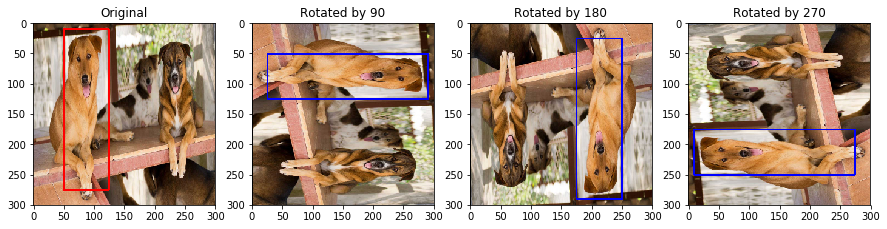

In [22]:
#Rotating
figure,axes = plt.subplots(1,4,figsize=(15,15))

img = cv2.imread('test_images/dog3.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(300,300))
x = [
    [50,10,125,275],
]
x = np.array(x).reshape(1,-1,4)
coordinates = x.reshape(-1,4).astype(int)
for i in range(coordinates.shape[0]):
    pt1 = (coordinates[i,0],coordinates[i,1])
    pt2 = (coordinates[i,2],coordinates[i,3])
    img = cv2.rectangle(img,pt1,pt2,(255,0,0),2)
axes[0].imshow(img)
axes[0].set_title('Original')


angle = 90
img = cv2.imread('test_images/dog3.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(300,300))
img = imutils.rotate_bound(img,angle)
x = [
    [50,10,125,275],
]
x = np.array(x).reshape(1,-1,4)
x = np_rotate_boxes(x,angle,150,150)
coordinates = x.reshape(-1,4).astype(int)
for i in range(coordinates.shape[0]):
    pt1 = (coordinates[i,0],coordinates[i,1])
    pt2 = (coordinates[i,2],coordinates[i,3])
    img = cv2.rectangle(img,pt1,pt2,(0,0,255),2)
axes[1].imshow(img)
axes[1].set_title('Rotated by 90')

angle = 180
img = cv2.imread('test_images/dog3.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(300,300))
img = imutils.rotate_bound(img,angle)
x = [
    [50,10,125,275],
]
x = np.array(x).reshape(1,-1,4)
x = np_rotate_boxes(x,angle,150,150)
coordinates = x.reshape(-1,4).astype(int)
for i in range(coordinates.shape[0]):
    pt1 = (coordinates[i,0],coordinates[i,1])
    pt2 = (coordinates[i,2],coordinates[i,3])
    img = cv2.rectangle(img,pt1,pt2,(0,0,255),2)
axes[2].imshow(img)
axes[2].set_title('Rotated by 180')

angle = 270
img = cv2.imread('test_images/dog3.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(300,300))
img = imutils.rotate_bound(img,angle)
x = [
    [50,10,125,275],
]
x = np.array(x).reshape(1,-1,4)
x = np_rotate_boxes(x,angle,150,150)
coordinates = x.reshape(-1,4).astype(int)
for i in range(coordinates.shape[0]):
    pt1 = (coordinates[i,0],coordinates[i,1])
    pt2 = (coordinates[i,2],coordinates[i,3])
    img = cv2.rectangle(img,pt1,pt2,(0,0,255),2)
axes[3].imshow(img)
axes[3].set_title('Rotated by 270')
coordinates

Text(0.5, 1.0, 'Flip horizontally and vertically')

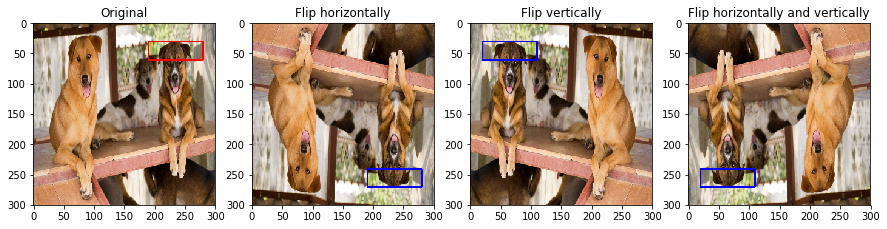

In [23]:
#Flip
figure,axes = plt.subplots(1,4,figsize=(15,15))

img = cv2.imread('test_images/dog3.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(300,300))

x = [
    [190,30,280,60],
]
x = np.array(x).reshape(1,-1,4)
coordinates = x.reshape(-1,4).astype(int)
for i in range(coordinates.shape[0]):
    pt1 = (coordinates[i,0],coordinates[i,1])
    pt2 = (coordinates[i,2],coordinates[i,3])
    img = cv2.rectangle(img,pt1,pt2,(255,0,0),2)
axes[0].imshow(img)
axes[0].set_title('Original')


#Flip horizontall(about x)
flip = 0
img = cv2.imread('test_images/dog3.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(300,300))
img = cv2.flip(img,flip)
x = [
    [190,30,280,60],
]
x = np.array(x).reshape(1,-1,4)
x = np_flip_boxes_about_xaxis(x,150)
coordinates = x.reshape(-1,4).astype(int)
for i in range(coordinates.shape[0]):
    pt1 = (coordinates[i,0],coordinates[i,1])
    pt2 = (coordinates[i,2],coordinates[i,3])
    img = cv2.rectangle(img,pt1,pt2,(0,0,255),2)
axes[1].imshow(img)
axes[1].set_title('Flip horizontally')

#Flip vertically(about y)
flip = 1
img = cv2.imread('test_images/dog3.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(300,300))
img = cv2.flip(img,flip)
x = [
    [190,30,280,60],
]
x = np.array(x).reshape(1,-1,4)
x = np_flip_boxes_about_yaxis(x,150)
coordinates = x.reshape(-1,4).astype(int)
for i in range(coordinates.shape[0]):
    pt1 = (coordinates[i,0],coordinates[i,1])
    pt2 = (coordinates[i,2],coordinates[i,3])
    img = cv2.rectangle(img,pt1,pt2,(0,0,255),2)
axes[2].imshow(img)
axes[2].set_title('Flip vertically')

#Flip about x and y
flip = -1
img = cv2.imread('test_images/dog3.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(300,300))
img = cv2.flip(img,flip)
x = [
    [190,30,280,60],
]
x = np.array(x).reshape(1,-1,4)
x = np_flip_boxes_about_xyaxis(x,150,150)
coordinates = x.reshape(-1,4).astype(int)
for i in range(coordinates.shape[0]):
    pt1 = (coordinates[i,0],coordinates[i,1])
    pt2 = (coordinates[i,2],coordinates[i,3])
    img = cv2.rectangle(img,pt1,pt2,(0,0,255),2)
axes[3].imshow(img)
axes[3].set_title('Flip horizontally and vertically')

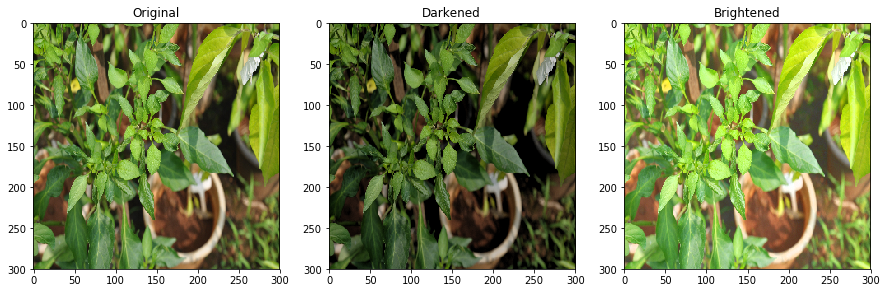

In [24]:
x = cv2.imread('data/leaf_data_v2/train/leaf_infected_0.jpg')
x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
x = cv2.resize(x,(300,300))
fig, axes =  plt.subplots(1,3,sharex=True,figsize=(15,15))
y = change_brightness(x,-50)
z = change_brightness(x,+50)
axes[0].set_title('Original')
axes[0].imshow(x)
axes[1].set_title('Darkened')
axes[1].imshow(y)
axes[2].set_title('Brightened')
axes[2].imshow(z)

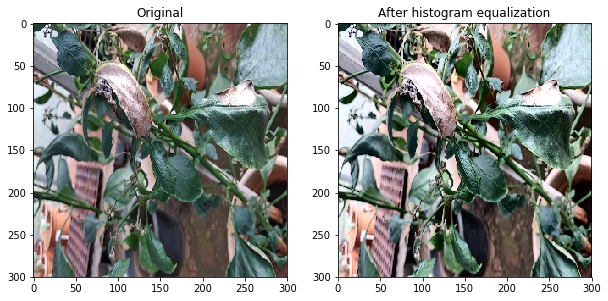

In [80]:
#Perform histogram equalization
fig, axes =  plt.subplots(1,2,sharex=True,figsize=(10,10))
x = cv2.imread('data/leaf_data_v2/train/leaf_infected_106.jpg')
x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
x = cv2.resize(x,(300,300))
axes[0].set_title('Original')
axes[0].imshow(x)
#Convert to Lab space from RGB space
x = cv2.cvtColor(x,cv2.COLOR_RGB2Lab)
#Intensity equalization of L values
x[:,:,0] = cv2.equalizeHist(x[:,:,0])
#Convert from Lab to RGB
x = cv2.cvtColor(x,cv2.COLOR_Lab2RGB)
axes[1].set_title('After histogram equalization')
axes[1].imshow(x)

## Dataset input pipeline 

In [25]:
def get_filename_parts(file_name):
    """
    Get parts of the file ie name and extension as tuple
    
    Args:
        file_name: string
    Returns:
        Tuple containing name and extension of file.
        If no extension then None is returned
    """
    search = re.search('(.*)\.(.*)$',file_name)
    if search is None:
        return None
    groups = search.groups()
    name = groups[0]
    ext = groups[1]
    return name, ext

In [26]:
get_filename_parts('something.xml')

('something', 'xml')

In [27]:
def read_annotation_file(file_path):
    """
    Read pascal VOC xml file
    Args:
        file_path: Pascal VOC xml file path
    Returns:
        panda frame containing class name and bounding boxes and original 
        height and width of image
        ['label','xmin','ymin','xmax','ymax', 'img_width','img_height']
    """
    xml = ET.parse(file_path)
    root = xml.getroot()
    data = []
    height = int(root.find('size').find('height').text,10)
    width = int(root.find('size').find('width').text,10)
    for object in root.findall('object'):
        name = object.find('name').text
        xmin = int(object.find('bndbox').find('xmin').text,10)
        ymin = int(object.find('bndbox').find('ymin').text,10)
        xmax = int(object.find('bndbox').find('xmax').text,10)
        ymax = int(object.find('bndbox').find('ymax').text,10)
        data.append([name,xmin,ymin,xmax,ymax,height,width])
    df = pd.DataFrame(data=data,columns=['label','xmin','ymin','xmax','ymax',
                                         'img_width','img_height'])
    return df


In [28]:
read_annotation_file('data/leaf_data_v3/train/sample_100.xml')

,label,xmin,ymin,xmax,ymax,img_width,img_height
0,advanced,979,614,1097,741,1115,1284
1,advanced,295,524,546,714,1115,1284
2,advanced,346,308,450,405,1115,1284
3,initial,1137,254,1278,344,1115,1284
4,advanced,770,690,899,770,1115,1284


In [29]:
def get_responsible_grid_cells(grid_centers, box_centers):
    """
    Get grid cells in which bounding boxes lie.
    Computed based on grid cell center closest to box center
    
    Args:
        grid_centers: Tensor of shape (GRID_SIZE, GRID_SIZE, 2)
        box_centers: Tensor of shape (N_BOX, 2)
    
    Returns:
        COO sparse matrix of shape (N_BOX, GRID_SIZE*GRID_SIZE)
        representing grid cell respondible for containing object.
    """
    centers = grid_centers
    boxes = box_centers
    
    #Get number of boxes
    n_boxes = boxes.shape[0]
    #Get grid size
    m_grid = centers.shape[0]
    #Get grid size
    n_grid = centers.shape[1]
    
    #Reshape centers to (grid_size*grid_size,2) and expand shape to (1,grid_size*grid_size,2)
    centers = centers.reshape(-1,2)
    centers = np.expand_dims(centers,axis=0)
    #Expand boxes to shape (n_box,1,2)
    boxes = np.expand_dims(boxes,axis=1)
    #copy centers along 0th axis. n_box copies are formed.
    #new shape is (n_box,grid_size*grid_size,2)
    centers = np.tile(centers,(boxes.shape[0],1,1))
    #copy boxes along 1st axis. grid_size*grid_size copies are formed.
    #new shape is (n_box,grid_size*grid_size,2)
    boxes = np.tile(boxes,(1,centers.shape[1],1))
    #compute squared distance between grid cell centers and box centers
    #(Xb - Xc)^2 + (Yb - Yc)^2.
    dist = np.square(boxes[:,:,0]-centers[:,:,0]) + np.square(boxes[:,:,1]-centers[:,:,1])
    #find minimum squared distance between a box and grid cell centers
    #assign this grid cell as containing an object
    #the shape of min_dist_cell is (n_box,1)
    min_dist_cell = np.argmin(dist,axis=1)
    idx = np.linspace(0,min_dist_cell.shape[0]-1,num=min_dist_cell.shape[0]).astype(int)
    ones = np.ones(idx.shape[0])
    coo_mat = scipy.sparse.coo_matrix((ones,(idx,min_dist_cell)),shape=(n_boxes,m_grid*n_grid))
    return coo_mat

In [30]:
grid = np_gen_anchors(3,3,[1,2])
grid_centers = grid[:,:,0,0:2]
box_centers = np.array(
    [
        [0.9,0.2],
        [0.2,0.9],
        [0.16,0.16],
        [0.5,0.4]
    ]
)
grid_centers

array([[[0.16666667, 0.16666667],
        [0.5       , 0.16666667],
        [0.83333333, 0.16666667]],

       [[0.16666667, 0.5       ],
        [0.5       , 0.5       ],
        [0.83333333, 0.5       ]],

       [[0.16666667, 0.83333333],
        [0.5       , 0.83333333],
        [0.83333333, 0.83333333]]])

In [31]:
mask = get_responsible_grid_cells(grid_centers,box_centers).toarray()
mask
#1st point lies in 3rd grid cell
#2nd point lies in 7th grid cell
#3rd point lies in 1st grid cell
#4th point lies in 5th ie central grid cell

array([[0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [32]:
def get_responsible_anchor_boxes(anchors,boxes):
    """
    Get anchor boxes which are responsible for detecting bounding boxes.
    Anchor box is reponsible for detecting bounding box if it has
    maximum IOU with it among other anchor boxes in the same grid cell. 
    
    Args:
        anchors: Tensor of shape (GRID_SIZE, GRID_SIZE,N_ANCHORS 4)
        boxes: Tensor of shape (N_BOX, 4)
    
    Returns:
        COO sparse matrix of shape (N_BOX*GRID_SIZE*GRID_SIZE,N_ANCHORS)
        representing anchor boxes responsible for containing object.
    """
    anchors = np.expand_dims(anchors,axis=0)
    anchors = np.tile(anchors,(boxes.shape[0],1,1,1,1))
    boxes = np.expand_dims(boxes,axis=1)
    boxes = np.expand_dims(boxes,axis=1)
    boxes = np.expand_dims(boxes,axis=1)
    boxes = np.tile(boxes,(1,anchors.shape[1],anchors.shape[2],anchors.shape[3],1))

    n_boxes = boxes.shape[0]
    m_grid = boxes.shape[1]
    n_grid = boxes.shape[2]
    n_anchors = boxes.shape[3]

    boxes = boxes.reshape((n_boxes*m_grid*n_grid,n_anchors,-1))
    anchors = anchors.reshape((n_boxes*m_grid*n_grid,n_anchors,-1))

    boxes = np_cvt_coord_to_diagonal(boxes)
    anchors = np_cvt_coord_to_diagonal(anchors)

    iou = np_intersection_over_union(boxes,anchors)
    iou = iou.reshape(n_boxes,m_grid,n_grid,n_anchors,-1)
    max_iou_anchor_idx = np.argmax(iou,axis=3)
    max_iou_anchor_idx = np.squeeze(max_iou_anchor_idx)

    iou = iou.reshape(n_boxes*m_grid*n_grid,-1)
    max_iou_anchor_idx = max_iou_anchor_idx.reshape(n_boxes*m_grid*n_grid)

    idx = np.linspace(0,stop=max_iou_anchor_idx.shape[0]-1,num=max_iou_anchor_idx.shape[0])
    idx = idx.astype(int)
    iou = np.max(iou,axis=1)
    ones = np.ones(shape=n_boxes*m_grid*n_grid)
    coo = scipy.sparse.coo_matrix((ones,(idx,max_iou_anchor_idx)),shape=(n_boxes*m_grid*n_grid,n_anchors))
    return coo

In [33]:
def get_unique_boxes_per_cell(anchors,boxes):
    """
    There might be two ground truth boxes which are in
    same grid cell. In this case we want only one groud truth box
    having highest IOU with any of the anchor in that cell. This is
    achieved using this function
    
    Args:
        anchors: Tensor of shape (GRID_SIZE, GRID_SIZE,N_ANCHORS 4)
        boxes: Tensor of shape (N_BOX, 4)
    
    Returns:
        COO sparse matrix of shape (N_BOX,GRID_SIZE*GRID_SIZE)
        representing anchor boxes responsible for containing object.
    """
    anchors = np.expand_dims(anchors,axis=0)
    anchors = np.tile(anchors,(boxes.shape[0],1,1,1,1))
    boxes = np.expand_dims(boxes,axis=1)
    boxes = np.expand_dims(boxes,axis=1)
    boxes = np.expand_dims(boxes,axis=1)
    boxes = np.tile(boxes,(1,anchors.shape[1],anchors.shape[2],anchors.shape[3],1))
    n_boxes = boxes.shape[0]
    m_grid = boxes.shape[1]
    n_grid = boxes.shape[2]
    n_anchors = boxes.shape[3]

    boxes = boxes.reshape((n_boxes*m_grid*n_grid,n_anchors,-1))
    anchors = anchors.reshape((n_boxes*m_grid*n_grid,n_anchors,-1))

    boxes = np_cvt_coord_to_diagonal(boxes)
    anchors = np_cvt_coord_to_diagonal(anchors)

    iou = np_intersection_over_union(boxes,anchors)
    iou = iou.reshape(n_boxes,m_grid,n_grid,n_anchors)
    
    max_iou_anchor = np.max(iou,axis=3)
    max_iou_gnd = np.max(max_iou_anchor,axis=0)
    max_iou_gnd_idx = np.argmax(max_iou_anchor,axis=0)
    max_iou_gnd_idx = max_iou_gnd_idx.reshape((-1))
    y = np.linspace(0,m_grid*n_grid-1,num=m_grid*n_grid).astype(int)
    ones = np.ones(m_grid*n_grid)
    coo = scipy.sparse.coo_matrix((ones,(max_iou_gnd_idx,y)),shape=(n_boxes,m_grid*n_grid))
    
    return coo

In [36]:
def get_true_responsible_anchors(anchors, boxes):
    """
    Get anchor boxes which are responsible for detecting bounding boxes.
    Computed based on anchor box having maximum IOU in a grid cell and 
    grid cell being responsible for its detection.
    
    Args:
        anchors: Tensor of shape (GRID_SIZE, GRID_SIZE,N_ANCHORS 4)
        boxes: Tensor of shape (N_BOX, 4)
    
    Returns:
        COO sparse matrix of shape (N_BOX*GRID_SIZE*GRID_SIZE,N_ANCHORS)
        representing anchor boxes responsible for containing object.
    """
    n_boxes = boxes.shape[0]
    m_grid = anchors.shape[0]
    n_grid = anchors.shape[1]
    n_anchors = anchors.shape[2]
    
    x = get_responsible_anchor_boxes(anchors,boxes)
    x = x.toarray()
    y = get_responsible_grid_cells(anchors[:,:,0,0:2],boxes[:,0:2])
    y = y.toarray()
    x = x.reshape(n_boxes,m_grid,n_grid,n_anchors)
    y = y.reshape(n_boxes,m_grid,n_grid)
    y = np.expand_dims(y,axis=3)
    y = np.tile(y,(1,1,1,n_anchors))
    z = x * y
    z = z.reshape((n_boxes*m_grid*n_grid,n_anchors))
    return scipy.sparse.coo_matrix(z)
    

In [37]:
class Dataset:
    """
    Dataset class to load data from dataset.
    """
    def __init__(self,data_path, image_w, image_h,
                 m_grid, n_grid, class_labels, anchor_dims,
                 shuffle=True, img_extensions=['jpg','jpeg'],
                 brightness_range=None, histogram_equ=False,
                 rotations=None,flips=None):
        """
        Args:
            data_path: path which contains image files and corresponding annotation files
            image_w: input image width
            image_h: input image height
            m_grid: grid size
            n_grid: grid size
            class_labels: list of classification labels
            anchors: list of anchor dimensions 
            shuffle: shuffle dataset. Default: True
            img_extensions: list of allowed image extensions. Default: ['jpg','jpeg']
            brightness_range: list of two values within which brightness is randomly varied
                if None then brightness is not changed
            histogram_equ: If true then perform histogram equalization. Default: false
            rotations: List of angles in multiples of 90. Values should be in degrees.
                    If None then no rotations are performed
            flips: list of flip codes. If none then no random flips are performed
                Allowed flip codes are 0(horizontal flip), 1(vertical flip),-1(flip about xy)
        """
        self.m_grid = m_grid
        self.n_grid = n_grid
        self.class_labels = class_labels
        self.anchor_dims = anchor_dims
        self.image_w = image_w
        self.image_h = image_h
        self.histogram_equ = histogram_equ
        self.brightness_range = brightness_range
        self.data_path = data_path
        self.flips = flips
        self.rotations = rotations
        
        #pandas frame to hold image path and annotation path
        self.data_files = pd.DataFrame(columns=['image','annotation'])
        self.shuffle = shuffle
        self.img_extensions = img_extensions
        
        self.create_data_file_frame()
        
        self.label_encoder = LabelEncoder()
        self.one_hot_encoder = OneHotEncoder()
        self.label_encoder.fit(self.class_labels)
        self.one_hot_encoder.fit(self.label_encoder.transform(self.class_labels).reshape(-1,1))
        
    def create_data_file_frame(self):
        """
        Create pandas frame of image, annotation values
        """
        #Get list of files from data path
        file_list = os.listdir(self.data_path)
        data = []
        #for each file name do the following
        for file_name in file_list:
            #get name and extension
            name, ext = get_filename_parts(file_name)
            #if the file is in allowed image extensions
            if ext in self.img_extensions:
                #check if corresponding annotation file exists and append to data frame is so
                if name+'.xml' in file_list:
                    data.append({'image':file_name,'annotation':name+'.xml'})
                #else throw  AnnotationFileNotFoundError 
                else:
                    raise AnnotationFileNotFoundError(name+'.xml')

        self.data_files =self.data_files.append(data)
        #if shuffle is enabled, shuffle the dataset
        if self.shuffle:
            self.data_files= shuffle(self.data_files)        
    
    def __len__(self):
        """
        Returns size of dataset ie number if image samples.
        """
        return self.data_files.shape[0]
    
    def __getitem__(self,idx):
        """
        Get image, y_true, mask at index idx
        """
        img, ann = self.get_sample(idx)
        
        #Get only center form coordinates of bounding boxes
        gnd_boxes = np.array(ann)[:,5:9]
        #Number of ground truth boxes
        n_boxes = gnd_boxes.shape[0]
        #Number of anchors per cell
        n_anchors = np.array(self.anchor_dims).reshape(-1,2).shape[0]
        
        #generate anchor boxes
        anchor_boxes = np_gen_anchors(self.m_grid, self.n_grid,
                                      self.anchor_dims)
        
        #get labels of all ground truth boxes and one hot encode them
        labels = ann['label']
        label_en = self.label_encoder.transform(labels).reshape(-1,1)
        one_hot_encoded = self.one_hot_encoder.transform(label_en).toarray()
        #Expand along GRID, GRID and ANCHOR dimensions
        one_hot_encoded = np.expand_dims(one_hot_encoded,axis=1)
        one_hot_encoded = np.expand_dims(one_hot_encoded,axis=1)
        one_hot_encoded = np.expand_dims(one_hot_encoded,axis=1)
        one_hot_encoded = np.tile(one_hot_encoded,(1,self.m_grid,self.n_grid,n_anchors,1))
        
        #Get bounding box coordinates and expand along GRID, GRID and ANCHOR dimensions
        gnd_box_coord = np.expand_dims(gnd_boxes,axis=1)
        gnd_box_coord = np.expand_dims(gnd_box_coord,axis=1)
        gnd_box_coord = np.expand_dims(gnd_box_coord,axis=1)
        gnd_box_coord = np.tile(gnd_box_coord,(1,self.m_grid,self.n_grid,n_anchors,1))
        
        #Compute IOU 
        a = np_cvt_coord_to_diagonal(np.expand_dims(gnd_boxes,axis=0))
        b = np_cvt_coord_to_diagonal(anchor_boxes.reshape(self.m_grid*self.n_grid,n_anchors,-1))
        
        #Expand a along GRID, GRID, ANCHORS dimensions
        a = a[0,:,:]
        a = np.expand_dims(a,axis=1)
        a = np.expand_dims(a,axis=1)
        a = np.expand_dims(a,axis=1)
        a = np.tile(a,(1,self.m_grid,self.n_grid,n_anchors,1))
        #Expand b along GND_BOX dimention
        b = b.reshape((self.m_grid,self.n_grid,n_anchors,-1))
        b = np.expand_dims(b,axis=0)
        b = np.tile(b,(n_boxes,1,1,1,1))
        
        a = a.reshape((-1,n_anchors,4))
        b = b.reshape((-1,n_anchors,4))
        
        iou = np_intersection_over_union(a,b)
        iou = iou.reshape(-1,self.m_grid,self.n_grid,n_anchors,1)
        
        #Generate mask
        x = get_true_responsible_anchors(anchor_boxes,gnd_boxes)
        x = x.toarray()
        x = x.reshape(n_boxes,self.m_grid,self.n_grid,n_anchors)
        y = get_unique_boxes_per_cell(anchor_boxes,gnd_boxes).toarray().reshape(n_boxes,self.m_grid,self.n_grid)
        y = np.expand_dims(y,axis=3)
        y = np.tile(y,(1,1,1,n_anchors))
        mask = x*y
        #Add dimension to mask at the end and expand
        mask = np.expand_dims(mask,axis=4)
        mask  = np.tile(mask,(1,1,1,1,4+1+len(self.class_labels)))
        
        out = np.concatenate((gnd_box_coord,iou,one_hot_encoded),axis=4)
        out = mask * out
        out = np.sum(out,axis=0)
#         print(one_hot_encoded.shape)
#         print(iou.shape)
#         print(gnd_box_coord.shape)
#         print(mask.shape)
#         print(out.shape)

        return img, out, mask
        
    
    def get_sample(self, idx):
        """
        Get image and its corresponding annotations in pandas frame
        """
        #Load the image from the training data 
        img = cv2.imread(os.path.join(
                self.data_path,
                self.data_files.iloc[idx,0]))
        #Load the corresponding annotation file from training data
        annotations = read_annotation_file(
                os.path.join(self.data_path,
                             self.data_files.iloc[idx,1]
                             ))
        
        
        #Get the image height and width
        org_height, org_width, _ = img.shape
        #Convert image from BGR to RGB space
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        #Resize image as per the height in configuration file
        img = cv2.resize(img,(self.image_w,
                                self.image_h))
        #histogram equalization
        if self.histogram_equ:
            img = cv2.cvtColor(img,cv2.COLOR_RGB2Lab)
            img[:,:,0] = cv2.equalizeHist(img[:,:,0])
            img = cv2.cvtColor(img,cv2.COLOR_Lab2RGB)
        
        #chnage brightness
        if self.brightness_range is not None:
            value = np.random.randint(self.brightness_range[0],
                                  self.brightness_range[1]+1)
            img = change_brightness(img,value)
        
        annotations = np.array(annotations)
        #This is done since some files have wrong values of height and width
        annotations[:,5] = org_width
        annotations[:,6] = org_height
        #normalize with respect to width and height
        annotations[:,1] = annotations[:,1] / annotations[:,5]
        annotations[:,2] = annotations[:,2] / annotations[:,6]
        annotations[:,3] = annotations[:,3] / annotations[:,5]
        annotations[:,4] = annotations[:,4] / annotations[:,6]
        
        
        boxes = annotations[:,1:5].reshape(-1,annotations.shape[0],4).astype(float)
        #perform random flip
        if self.flips is not None:
            flip_code = np.random.choice(self.flips)
            #If flip_code is not None then flip
            if flip_code is not None:
                img = cv2.flip(img,flip_code)
                #horizontal flip
                if flip_code == 0:
                    boxes = np_flip_boxes_about_xaxis(boxes,0.5)
                #vertical flip
                elif flip_code == 1:
                    boxes = np_flip_boxes_about_yaxis(boxes,0.5)
                #flip vertically and horizontally
                elif flip_code == -1:
                    boxes = np_flip_boxes_about_xyaxis(boxes,0.5,0.5)

                
        #perform random rotation
        if self.rotations is not None:
            angle = np.random.choice(self.rotations)
            img = imutils.rotate_bound(img,angle)
            boxes = np_rotate_boxes(boxes,angle,0.5,0.5)
            
        boxes = boxes.reshape(-1,4)
        annotations[:,1:5] = boxes
        
        #convert bounding box to xc, yc, w, h format
        cvt_coordinates = np_cvt_coord_to_mid_point(annotations[:,1:5].reshape(-1,annotations.shape[0],4))
        cvt_coordinates = np.squeeze(cvt_coordinates,axis=0)
        annotations = pd.DataFrame(annotations,columns=['label', 'xmin', 'ymin', 
                                                        'xmax', 'ymax','img_width', 'img_height'])
        cvt_coordinates = pd.DataFrame(cvt_coordinates,columns=['xc', 'yc', 'w', 'h'])
        annotations = pd.concat([annotations,cvt_coordinates],axis=1)
        cols = ['label', 'xmin', 'ymin', 'xmax', 'ymax',
       'xc', 'yc', 'w', 'h','img_width', 'img_height']
        annotations = annotations[cols]
        return img / 255.0, annotations    

In [38]:
def plot_true_tensor(img,y,img_w,img_h,m_grid,n_grid,
                     n_anchors,anchor_dim,en1,en2,
                    show_label=True,show_anchor=True,show_grid_cell_center=True):
    """
    Plots true tensor on a image. The grid cell centers are shown in green.
    Ground truth boxes and its center are marked in red.
    Blue boxes are corresponding anchor boxes responsible for prediction
    of ground truth box.
    
    Args:
        img: Image tensor
        y: True tensor
        img_w : width of image
        img_h: height of image
        m_grid: grid rows
        n_grid: grid columns
        n_anchors: number of anchors per grid cell
        anchor_dim: dimensions of anchor boxes
        en1: One hot encoder
        en2: Label encoder
        show_label: Show class label corresponding to ground truth box. Default: True
        show_lanchor: Show anchor box corresponding to ground truth box. Default: True
        show_grid_cell_center: Show grid cell centers. Default: True
    """
    anchors = np_gen_anchors(m_grid,n_grid,anchor_dim)
    for i in range(m_grid):
        for j in range(n_grid):

            #plot green dot corresponding to center of grid cell
            if show_grid_cell_center:
                a = anchors[i,j,0,0:4]
                x1 = int(np.round(img_w*a[0]))
                y1 = int(np.round(img_h*a[1]))
                pt1 = (x1,y1)
                img = cv2.circle(img,pt1,2,(0,255,0),2)

            for k in range(n_anchors):
                label = y[i,j,k,5:].reshape(1,-1)
                b = y[i,j,k,0:4]
                c = y[i,j,k,4]
                if c!=0:
                    #get label
                    label = en1.inverse_transform(label).astype(int)
                    label = label.reshape(-1)
                    label = en2.inverse_transform(label)

                    #plot red dot corresponding to center of gnd truth box
                    
                    x1 = int(np.round(img_w*b[0]))
                    y1 = int(np.round(img_h*b[1]))
                    pt1 = (x1,y1)
                    img = cv2.circle(img,pt1,3,(255,0,0),3)

                    b = np.expand_dims(b,axis=0)
                    b = np.expand_dims(b,axis=0)
                    b = np_cvt_coord_to_diagonal(b)
                    b = b[0,0,:]

                    x1 = int(np.round(img_w*b[0]))
                    y1 = int(np.round(img_h*b[1]))
                    x2 = int(np.round(img_w*b[2]))
                    y2 = int(np.round(img_h*b[3]))
                    pt1 = (x1,y1)
                    pt2 = (x2, y2)

                    img = cv2.rectangle(img,pt1,pt2,(255,0,0),2)
                    #put label on image
                    if show_label:
                        img = cv2.putText(img,label[0],pt1,cv2.FONT_HERSHEY_COMPLEX,0.75,(32,52,32),2)
                    #Print corresponding anchor box in blue
                    if show_anchor:
                        a = anchors[i,j,k,0:4]
                        a = np.expand_dims(a,axis=0)
                        a = np.expand_dims(a,axis=0)
                        a = np_cvt_coord_to_diagonal(a)
                        a = a[0,0,:]

                        x1 = int(np.round(img_w*a[0]))
                        y1 = int(np.round(img_h*a[1]))
                        x2 = int(np.round(img_w*a[2]))
                        y2 = int(np.round(img_h*a[3]))
                        pt1 = (x1,y1)
                        pt2 = (x2, y2)

                        img = cv2.rectangle(img,pt1,pt2,(0,0,255),2)
    plt.imshow(img)

C:\Users\siddh\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


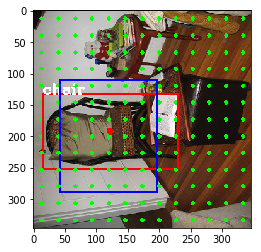

In [39]:
dataset = Dataset('data/pascal_voc/test/',346,346,
                  13,13,
                  ['chair', 'car', 'horse', 'person', 'bicycle', 'cat', 'dog',
       'train', 'aeroplane', 'diningtable', 'tvmonitor', 'bird', 'bottle',
       'motorbike', 'pottedplant', 'boat', 'sofa', 'sheep', 'cow', 'bus'],
                  [0.44752974, 0.51667883, 0.17638203, 0.16553482, 0.076274  ,
       0.10540195, 0.10295663, 0.23137522, 0.24225889, 0.3452266 ],
                  shuffle=False,histogram_equ=False,brightness_range=[-10,10]
                 ,flips=[None,-1,0,1],rotations=[0,90,180,270])

X, y, out = dataset[5]
plot_true_tensor(X,y,346,346,13,13,5, [0.44752974, 0.51667883, 0.17638203, 0.16553482, 0.076274  ,
       0.10540195, 0.10295663, 0.23137522, 0.24225889, 0.3452266 ],dataset.one_hot_encoder,dataset.label_encoder,
                show_anchor=True,show_grid_cell_center=True,show_label=True)

In [40]:
def np_gen_anchors_with_top_corner(fx,fy,dim):
    """
    Generate anchor boxes of the form [xc,yc,w,h]
    Here xc and yc are the coordinates of top left
    corner of the grid cell
    Args:
        fx: width of grid size
        fy: height of grid size
        dim: list of coordinates of the form [xc,yc,w,h]
        
    Returns:
        Tensor of shape (fx, fy, n_anchors, 4)
    """
    xc = np.linspace(0,fx,endpoint=False,num=fx).reshape(-1,fx)
    yc = np.linspace(0,fy,endpoint=False,num=fy).reshape(fy,-1)
    xc = np.tile(xc,(fy,1))
    yc = np.tile(yc,(1,fx))

    xc = xc.reshape(fx,fy,-1)
    yc = yc.reshape(fx,fy,-1) 
    
    xc = (xc) / fx
    yc = (yc) / fy
    
    c = np.concatenate((xc,yc),axis=2)
    c = np.expand_dims(c,axis=0)
    

    dim = np.array(dim).reshape(-1,2)
    dim = np.expand_dims(dim,axis=1)
    dim = np.expand_dims(dim,axis=2)
    dim = np.tile(dim,(1,fx,fy,1))

    c = np.tile(c,(dim.shape[0],1,1,1))
    anchors = np.concatenate((c,dim),axis=3)
    anchors = np.transpose(anchors,(1,2,0,3))
    return anchors

In [41]:
np_gen_anchors_with_top_corner(3,3,[1,2])

array([[[[0.        , 0.        , 1.        , 2.        ]],

        [[0.33333333, 0.        , 1.        , 2.        ]],

        [[0.66666667, 0.        , 1.        , 2.        ]]],


       [[[0.        , 0.33333333, 1.        , 2.        ]],

        [[0.33333333, 0.33333333, 1.        , 2.        ]],

        [[0.66666667, 0.33333333, 1.        , 2.        ]]],


       [[[0.        , 0.66666667, 1.        , 2.        ]],

        [[0.33333333, 0.66666667, 1.        , 2.        ]],

        [[0.66666667, 0.66666667, 1.        , 2.        ]]]])

In [42]:
def tf_gen_anchors_with_top_corner(fx,fy,dim):
    """
    Generate anchor boxes of the form [xc,yc,w,h]
    Here xc and yc are the coordinates of top left
    corner of the grid cell
    Args:
        fx: width of grid size
        fy: height of grid size
        dim: list of coordinates of the form [xc,yc,w,h]
        
    Returns:
        Tensor of shape (fx, fy, n_anchors, 4)
    """
    
    xc = tf.lin_space(0.0,fx-1,num=fx)
    xc = tf.reshape(xc,(-1,fx))
    yc = tf.lin_space(0.0,fy-1,num=fy)
    yc = tf.reshape(yc,(fy,-1))
    
    xc = tf.tile(xc,(fy,1))
    yc = tf.tile(yc,(1,fx))

    xc = tf.reshape(xc,(fx,fy,-1))
    yc = tf.reshape(yc,(fx,fy,-1)) 
    
    xc = (xc) / fx
    yc = (yc) / fy
    
    c = tf.concat((xc,yc),axis=2)
    c = tf.expand_dims(c,axis=0)
    

    dim = tf.convert_to_tensor(dim)
    dim = tf.cast(dim,dtype=tf.float32)
    dim = tf.reshape(dim,(-1,2))
    dim = tf.expand_dims(dim,axis=1)
    dim = tf.expand_dims(dim,axis=2)
    dim = tf.tile(dim,(1,fx,fy,1))

    c = tf.tile(c,(dim.shape[0],1,1,1))
    anchors = tf.concat((c,dim),axis=3)
    anchors = tf.transpose(anchors,(1,2,0,3))
    return anchors

## YOLOv2 Network

### YOLOv2 output layer

This layer performs direct location prediction using following formulas. It also outputs C conditional class probabilities. 

<img src="notebook_images/direct_location.PNG"> </img>
<br>
<img src="notebook_images/direct_location2.PNG"> </img>
<br>
<img src="notebook_images/softmax.PNG"> </img>

In [43]:
class YoloOutputLayer(tf.keras.layers.Layer):
    """
    Yolo output layer which performs direct location prediction.
    Reorg is not implemented as of now.
    """
    def __init__(self,m_grid,n_grid,batch_size,anchor_dim,**kwargs):
        """
        Args:
            m_grid: grid size
            n_grid: grid_size
            batch_size: input batch size
            anchor_dim: anchor dimensions
        """
        self.anchor_dim = anchor_dim
        self.m_grid = m_grid
        self.n_grid = n_grid
        self.batch_size = batch_size
        
        #Generate anchor boxes in all grid cells with top left corner of grid cell.
        self.anchor_boxes = np_gen_anchors_with_top_corner(self.m_grid,self.n_grid,self.anchor_dim)
        #Create copies for batch_size samples
        self.anchor_boxes = np.expand_dims(self.anchor_boxes,axis=0)
        self.anchor_boxes = np.tile(self.anchor_boxes,(self.batch_size,1,1,1,1))
        
        super(YoloOutputLayer, self).__init__(**kwargs)

    def build(self, input_shape):        
        # Make sure to call the `build` method at the end
        super(YoloOutputLayer, self).build(input_shape)

    def call(self, inputs):
#         self.anchor_boxes = tf_gen_anchors_with_top_corner(self.m_grid,self.n_grid,self.anchor_dim)
#         self.anchor_boxes = tf.expand_dims(self.anchor_boxes,axis=0)
#         self.anchor_boxes = tf.tile(self.anchor_boxes,(self.batch_size,1,1,1,1))
        
        centers = inputs[:,:,:,:,0:2]
        dimensions = inputs[:,:,:,:,2:4]
        confidences = inputs[:,:,:,:,4:5]
        class_probabilities = inputs[:,:,:,:,5:]
        

        a_centers = self.anchor_boxes[:,:,:,:,0:2]
        a_dimensions = self.anchor_boxes[:,:,:,:,2:4]
        
        # Xc = sigmoid(tc) + cx Yc = sigmoid(tc) + cy
        r_centers = tf.sigmoid(centers) + a_centers
        # w= Pw * e^(tw)  h= Ph * e^(th)
        r_dimensions = a_dimensions*tf.exp(dimensions)
        #conf = sigmoid(tconf)
        r_confidences = tf.sigmoid(confidences)
        #softmax over n_classes classes
        r_class_probabilities = tf.math.softmax(class_probabilities)
        
        #final output
        r_output = tf.concat((r_centers,r_dimensions,r_confidences,r_class_probabilities),axis=4)
        return r_output

    def compute_output_shape(self, input_shape):
        #output shape is same as input
        return input_shape

    def get_config(self):
        base_config = super(YoloOutputLayer, self).get_config()
        base_config['anchor_dim'] = self.anchor_dim
        base_config['m_grid'] = self.m_grid
        base_config['n_grid'] = self.n_grid
        return base_config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

### Network
Our network is based on VGG-16 architecture to which we added more layers so the final feature map is 13*13
<br>
VGG-16 Architecture is given below. We use pretrained convlutional layers from vgg-16 model.
<br>
<img src='notebook_images/vgg.PNG' width='500px'></img>

In [44]:
class YoloNetwork(tf.keras.models.Model):
    
    def __init__(self,
                 image_w,image_h,
                 m_grid,n_grid,
                 n_anchors,
                 n_classes,
                 batch_size,
                 anchor_dims):
        """
        Initialize network
        Args:
            image_w: input image width
            image_h: input image height
            m_grid: grid size
            n_grid: grid size
            n_anchors: Number of anchors
            n_classes: Number of classes
            batch_size: Input batch size
            anchor_dims: anchor box dimensions
        """
        super(YoloNetwork, self).__init__()
        
        self.batch_size = batch_size
        self.image_w = image_w
        self.image_h = image_h
        self.m_grid = m_grid
        self.n_grid = n_grid
        self.n_anchors = n_anchors
        self.n_classes = n_classes
        self.anchor_dims = anchor_dims
        
        self.resnet = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                                   weights='imagenet',
                                                                   input_shape=(self.image_h,self.image_w,3))

        self.conv2d_layer_1 = tf.keras.layers.Conv2D(filters=1024,kernel_size=(1,1),activation='relu')
        self.conv2d_layer_2 = tf.keras.layers.Conv2D(filters=n_anchors*(5+n_classes),kernel_size=(1,1),activation='relu')
        self.yolo_out_layer = YoloOutputLayer(self.m_grid,
                                              self.n_grid,
                                              self.batch_size,
                                              self.anchor_dims)
        
    def call(self, input):
        """Run the model."""
        out = self.resnet(input)
        out = self.conv2d_layer_1(out)
        out = self.conv2d_layer_2(out)
        out = tf.reshape(out,(-1,self.m_grid,self.n_grid,self.n_anchors,5+self.n_classes))
        out = self.yolo_out_layer(out)
        
        return out

In [45]:
def get_pre_trained_model_resnet(image_w,image_h,    
                 m_grid,n_grid,
                 n_anchors,
                 n_classes,
                 batch_size,
                 anchor_dims):
    
    resnet = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                                   weights='imagenet',
                                                                   input_shape=(image_h,image_w,3))
    conv1_out = tf.keras.layers.Conv2D(1024,(1,1),strides=(1,1),padding='valid',activation='relu')(resnet.output)
    conv2_out = tf.keras.layers.Conv2D(n_anchors*(5+n_classes),(1,1),
                                       strides=(1,1),padding='valid',activation='relu')(conv1_out)
    conv2_out = tf.keras.layers.Reshape((m_grid,n_grid,n_anchors,5+n_classes))(conv2_out)
    yolo_out_layer = YoloOutputLayer(m_grid,
                                              n_grid,
                                              batch_size,
                                           anchor_dims)
    yolo_out = yolo_out_layer(conv2_out)

    model = tf.keras.Model(inputs = resnet.input, outputs = yolo_out)
    return model

In [46]:
def get_pre_trained_model_vgg16( image_w,image_h,
                 m_grid,n_grid,
                 n_anchors,
                 n_classes,
                 batch_size,
                 anchor_dims):
    
    input = tf.keras.layers.Input(shape=(image_h,image_w,3))
    model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(image_h,image_w,3),
                                              input_tensor=input)

    layer = model.layers[-2].output
    layer = tf.keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='valid',activation='relu')(layer)
    layer = tf.keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='valid',activation='relu')(layer)
    layer = tf.keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='valid',activation='relu')(layer)
    layer = tf.keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='valid',activation='relu')(layer)
    layer = tf.keras.layers.Conv2D(256,(1,1),strides=(1,1),padding='valid',activation='relu')(layer)
    layer = tf.keras.layers.Conv2D(n_anchors*(5+n_classes),(1,1),strides=(1,1),padding='valid')(layer)
    layer = tf.keras.layers.Reshape((m_grid,n_grid,n_anchors,5+n_classes))(layer)
    yolo_out_layer = YoloOutputLayer(m_grid,
                                              n_grid,
                                              batch_size,
                                           anchor_dims)
    yolo_out = yolo_out_layer(layer)
    model = tf.keras.Model(inputs=input,outputs=yolo_out)
    return model

In [48]:
model = get_pre_trained_model_vgg16(346,346,13,13,3,2,2,[0.44752974, 0.51667883, 0.17638203, 0.16553482, 0.076274  ,
        0.10540195])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 346, 346, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 346, 346, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 346, 346, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 173, 173, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 173, 173, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 173, 173, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 86, 86, 128)       0         
__________

### YOLOv2 loss functions as defined below

<img src="notebook_images/loss.PNG" width="500px"> </img>

In [63]:
def yolo_reg_loss(y_true,y_pred,lambda_coord,mask):
    """
    Yolo regression loss
    """
    centers_true = y_true[:,:,:,:,0:2]
    centers_pred = y_pred[:,:,:,:,0:2]
    centers_mask = mask[:,:,:,:,0:2]
    
    centers_loss = centers_mask * tf.square(centers_true - centers_pred)
    centers_loss = tf.reduce_sum(centers_loss,axis=4)
    centers_loss = tf.reduce_sum(centers_loss,axis=3)
    centers_loss = tf.reduce_sum(centers_loss,axis=2)
    centers_loss = tf.reduce_sum(centers_loss,axis=1)
    centers_loss = lambda_coord*centers_loss
    
    dim_true = y_true[:,:,:,:,2:4]
    dim_pred = y_pred[:,:,:,:,2:4]
    dim_mask = mask[:,:,:,:,2:4]
    
    dim_true = tf.sqrt(dim_true)
    dim_pred = tf.sqrt(dim_pred)
    dim_loss =  dim_mask * tf.square(dim_true - dim_pred)
    dim_loss = tf.reduce_sum(dim_loss,axis=4)
    dim_loss = tf.reduce_sum(dim_loss,axis=3)
    dim_loss = tf.reduce_sum(dim_loss,axis=2)
    dim_loss = tf.reduce_sum(dim_loss,axis=1)
    dim_loss = lambda_coord*dim_loss
    
    reg_loss = centers_loss + dim_loss
    return reg_loss

In [64]:
def yolo_confidence_loss(y_true,y_pred,lambda_noobj,mask):
    """
    Yolo confidence loss
    """
    conf_true = y_true[:,:,:,:,4:5]
    conf_pred = y_pred[:,:,:,:,4:5]
    conf_mask = mask[:,:,:,:,4:5]
    
    conf_diff = tf.square(conf_true - conf_pred)
    
    pos_conf_loss = conf_mask*conf_diff
    pos_conf_loss = tf.reduce_sum(pos_conf_loss,axis=4)
    pos_conf_loss = tf.reduce_sum(pos_conf_loss,axis=3)
    pos_conf_loss = tf.reduce_sum(pos_conf_loss,axis=2)
    pos_conf_loss = tf.reduce_sum(pos_conf_loss,axis=1)
    
    conf_mask_noobj = tf.cast(conf_mask,dtype=tf.bool)
    conf_mask_noobj = tf.logical_not(conf_mask_noobj)
    conf_mask_noobj = tf.cast(conf_mask_noobj,dtype=tf.float32)
    
    neg_conf_loss = conf_mask_noobj*conf_diff
    neg_conf_loss = tf.reduce_sum(neg_conf_loss,axis=4)
    neg_conf_loss = tf.reduce_sum(neg_conf_loss,axis=3)
    neg_conf_loss = tf.reduce_sum(neg_conf_loss,axis=2)
    neg_conf_loss= tf.reduce_sum(neg_conf_loss,axis=1)

    
    conf_loss = pos_conf_loss + lambda_noobj*neg_conf_loss
    return conf_loss

In [65]:
def yolo_classification_loss(y_true,y_pred,mask):
    """
    Yolo classification loss
    """
    class_true = y_true[:,:,:,:,5:]
    class_pred = y_pred[:,:,:,:,5:]
    class_mask = mask[:,:,:,:,5]
    
    class_loss = class_true - class_pred
    class_loss = tf.square(class_loss)
    class_loss = tf.reduce_sum(class_loss,axis=4)
    class_loss = class_mask * class_loss
    class_loss = tf.reduce_sum(class_loss,axis=3)
    class_loss = tf.reduce_sum(class_loss,axis=2)
    class_loss = tf.reduce_sum(class_loss,axis=1)
    return class_loss
    

In [66]:
def yolo_net_loss(y_true,y_pred,lambda_coord,lambda_noobj,mask):
    """
    Net yolo loss
    """
    loss = yolo_reg_loss(y_true,y_pred,lambda_coord,mask) +\
        yolo_confidence_loss(y_true,y_pred,lambda_noobj,mask) +\
        yolo_classification_loss(y_true,y_pred,mask)
    return loss

In [67]:
def get_batch(dataset,step,batch_size):
    """
    Form batches of dataset as if dataset is circular queue.
    """
    n_samples = len(dataset)
    idx = step*batch_size
    idx = idx % n_samples
    imgs = []
    y_trues = []
    masks = []
    for j in range(batch_size):
        X, y, mask = dataset[idx]
        idx = (idx +1) % n_samples
        X = np.expand_dims(X,axis=0).astype(np.float32)
        y = np.expand_dims(y,axis=0).astype(np.float32)
        mask = mask.sum(axis=0).astype(np.float32)
        mask = np.expand_dims(mask,axis=0)
        
        imgs.append(X)
        y_trues.append(y)
        masks.append(mask)
        
    imgs = np.concatenate(imgs,axis=0)
    y_trues = np.concatenate(y_trues,axis=0)
    masks = np.concatenate(masks,axis=0)
    return imgs, y_trues, masks

### Training YOlOv2

In [68]:
#MODEL paramaters for leaf_data_v2
epochs = 200
image_h = 346
image_w = 346
m_grid = 13
n_grid = 13
anchor_dim = [0.17418965, 0.24217035,
        0.08529647, 0.12489262,
        0.3669517,  0.45720006]

n_anchors = int(len(anchor_dim) / 2)
lambda_coord = 1.0
lambda_noobj =  1.0
batch_size = 5
learning_rate = 0.0001
class_labels = ['infected','not_infected']
n_classes = len(class_labels)



In [69]:
model = get_pre_trained_model_vgg16(image_w,image_h,
                 m_grid,n_grid,
                 n_anchors,
                 n_classes,
                 batch_size,
                 anchor_dim)

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 346, 346, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 346, 346, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 346, 346, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 173, 173, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 173, 173, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 173, 173, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 86, 86, 128)       0         
__________

In [71]:
#Training setup
train_dataset = Dataset('data/leaf_data_v2/train/',image_w,image_h,m_grid,n_grid,
                       class_labels,anchor_dim,shuffle=True,brightness_range=[-10,10],flips=[None,-1,0,1],
                       rotations=[0,90,180,270],histogram_equ=True)

test_dataset = Dataset('data/leaf_data_v2/test/',image_w,image_h,m_grid,n_grid,
                       class_labels,anchor_dim,shuffle=False)

train_steps = np.ceil(len(train_dataset) / batch_size).astype(int)
test_steps = np.ceil(len(test_dataset) / batch_size).astype(int)

train_loader_scale =  np.ceil(train_steps / 10).astype(int)
test_loader_scale = np.ceil(test_steps / 10).astype(int)

yolo_network = get_pre_trained_model_vgg16(image_w,image_h,m_grid,n_grid,3,2,1,anchor_dim)
yolo_network.build((batch_size,image_h,image_h,3))
yolo_network.summary()
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

C:\Users\siddh\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\siddh\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 346, 346, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 346, 346, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 346, 346, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 173, 173, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 173, 173, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 173, 173, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 86, 86, 128)       0         
__________

In [72]:
train_loss_history = []
test_loss_history = []

In [ ]:
for i in range(epochs):
    total_loss = 0.0
    print('Epoch {}'.format(i))
    for j in range(train_steps):
        if j % train_loader_scale == 0:
            print('#',end='')
        X, y, mask = get_batch(train_dataset,j,batch_size)
        with tf.GradientTape() as tape:
            y_pred = yolo_network(X)
            loss = tf.reduce_mean(yolo_net_loss(y,y_pred,lambda_coord,lambda_noobj,mask))
        grad = tape.gradient(loss, yolo_network.trainable_variables)
        optimizer.apply_gradients(zip(grad, yolo_network.trainable_variables),
                            global_step=tf.train.get_or_create_global_step())
        total_loss += batch_size * loss
    avg_loss = total_loss / (batch_size*train_steps)
    train_loss_history.append((i,avg_loss))
    
    #evaluate on test dataset
    print('\nEvaluating on test dataset')
    total_loss = 0
    for j in range(test_steps):
        if j % test_loader_scale == 0:
            print('#',end='')
        X, y, mask = get_batch(test_dataset,j,batch_size)
        y_pred = yolo_network(X)
        loss = tf.reduce_mean(yolo_net_loss(y,y_pred,lambda_coord,lambda_noobj,mask))
        total_loss += batch_size * loss
    avg_loss = total_loss / (batch_size*test_steps)
    test_loss_history.append((i,avg_loss))
    print('\nTrain Loss={}, Test Loss={}'.format(train_loss_history[i][1],
                                                test_loss_history[i][1]))
    yolo_network.save_weights('yolo_net_epoch_'+str(i)+'.h5')

In [ ]:
# train_loss_history = [(1,2),(2,3),(3,3)]
# test_loss_history = [(1,3),(2,1),(3,5)]

train_loss_history = np.array(train_loss_history)
test_loss_history = np.array(test_loss_history)

plt.title('Training plot(Epochs vs Loss)')
plt.xticks(ticks=train_loss_history[:,0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss_history[:,0],train_loss_history[:,1],label='Train Loss')
plt.plot(test_loss_history[:,0],test_loss_history[:,1],label='Test Loss')
plt.legend(loc=0)

## Testing Trained models here

In [50]:
#Model parameters for leaf datav2
epochs = 100
image_h = 346
image_w = 346
m_grid = 13
n_grid = 13
anchor_dim =  [0.17418965, 0.24217035,
        0.08529647, 0.12489262,
        0.3669517,  0.45720006]
n_anchors = int(len(anchor_dim) / 2)
batch_size = 1
class_labels = ['infected','not_infected']
n_classes = len(class_labels)

In [125]:
# #Model parameters for leaf datav3
# epochs = 200
# image_h = 346
# image_w = 346
# m_grid = 13
# n_grid = 13
# anchor_dim = [0.10357705, 0.20360862, 0.07145229, 0.13264676, 0.14132441,
#         0.11088934, 0.06590009, 0.07748734, 0.2029387 , 0.24747141]

# n_anchors = int(len(anchor_dim) / 2)
# lambda_coord = 5.0
# lambda_noobj =  0.5
# batch_size = 1
# learning_rate = 0.0001
# class_labels = ['advanced', 'healthy', 'initial', 'moderate']
# n_classes = len(class_labels)


In [51]:
test_dataset = Dataset('data/leaf_data_v2/test/',image_w,image_h,m_grid,n_grid,
                       class_labels,anchor_dim,shuffle=False)
model = get_pre_trained_model_vgg16(image_w,image_h,
                 m_grid,n_grid,
                 n_anchors,
                 n_classes,
                 batch_size,
                 anchor_dim)
model.load_weights('trained_weights/leaf_data_v2/model_weights_16_leaf_v2.h5')
model.summary()

C:\Users\siddh\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 346, 346, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 346, 346, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 346, 346, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 173, 173, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 173, 173, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 173, 173, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 86, 86, 128)       0         
__________

In [57]:
tf.reset_default_graph()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[9.9630105e-01 3.6989755e-03]
 [9.9938822e-01 6.1172497e-04]
 [9.9088937e-01 9.1106016e-03]
 [9.8981196e-01 1.0187985e-02]
 [9.6871525e-01 3.1284727e-02]
 [9.9680138e-01 3.1985720e-03]
 [9.8123574e-01 1.8764237e-02]
 [9.9385577e-01 6.1442414e-03]
 [9.6200550e-01 3.7994530e-02]
 [9.9400216e-01 5.9977877e-03]]


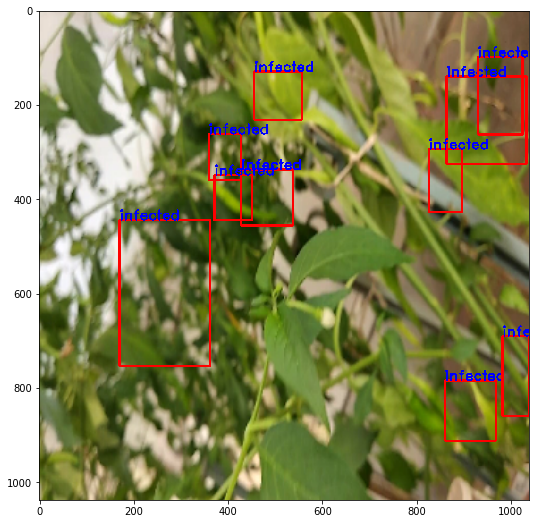

In [93]:
#Get image at index 
img_idx = 10
resize_factor = 3
X, y, mask = get_batch(test_dataset,img_idx,5)
y_pred = model(X).numpy()
y_pred = y_pred.reshape(-1,5+n_classes)
y_pred_coord = y_pred[:,0:4]
y_pred_conf = y_pred[:,4]
y_pred_classes = y_pred[:,5:]

y_pred_coord = np_cvt_coord_to_diagonal(y_pred_coord.reshape(1,-1,4))[0]
# y_pred[:,0:4] = y_pred_coord
# boxes = non_max_suppression(y_pred,0.4,0.02)

idx = tf.image.non_max_suppression(y_pred_coord,y_pred_conf,10,iou_threshold=0.5,score_threshold=0.3)

if idx.shape[0] == 0:
    idx = tf.image.non_max_suppression(y_pred_coord,y_pred_conf,2,iou_threshold=0.5)
    
idx = idx.numpy()
conf = y_pred_conf[idx.reshape(1,-1)][0]
boxes = y_pred_coord[idx.reshape(1,-1)][0]
boxes = np.clip(boxes,0,1.0)
boxes = np.round(resize_factor*image_h*boxes,decimals=1).astype(int)
classes = y_pred_classes[idx.reshape(1,-1)][0]
print(classes)
classes = test_dataset.one_hot_encoder.inverse_transform(classes)
classes = classes.flatten().astype(int)
classes = test_dataset.label_encoder.inverse_transform(classes)
img = X[0]
img = cv2.resize(img,(resize_factor*image_h,resize_factor*image_w))
boxes = boxes.reshape(-1,4)
for i in range(boxes.shape[0]):
    pt1 = (boxes[i][0],boxes[i][1])
    pt2 = (boxes[i][2],boxes[i][3])
    img = cv2.rectangle(img,pt1,pt2,(255,0,0),3)
    img = cv2.putText(img,classes[i],pt1, cv2.FONT_HERSHEY_DUPLEX, 1.0, (0,0,255),2)
plt.figure(figsize=(9,9))
plt.imshow(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(204, 25) (263, 122)
(264, 10) (312, 45)
(124, 88) (228, 346)
(254, 0) (338, 74)


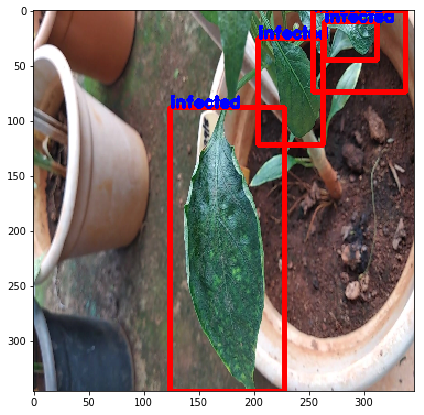

In [55]:
#Get your own image
resize_factor = 3
# image_path = 'test_images/leaf_not_infected_30.jpg'
# image_path = 'test_images/leaf_not_infected_24.jpg'
image_path = 'test_images/leaf_infected_58.jpg'
# image_path = 'test_images/leaf_infected_49.jpg'
# image_path = 'test_images/leaf_infected_8.jpg'
# image_path = 'test_images/leaf_infected_367.jpg'
X = cv2.imread(image_path)
X = cv2.cvtColor(X,cv2.COLOR_BGR2RGB)
org_h = 346
org_w = 346
original_image = np.copy(X)
X = cv2.resize(X,(image_h,image_w))
X = X / 255.0
X = X.astype(np.float32)
X = X.reshape(-1,image_h,image_w,3)

y_pred = model(X).numpy()
y_pred = y_pred.reshape(-1,5+n_classes)
y_pred_coord = y_pred[:,0:4]
y_pred_conf = y_pred[:,4]
y_pred_classes = y_pred[:,5:]

y_pred_coord = np_cvt_coord_to_diagonal(y_pred_coord.reshape(1,-1,4))[0]
idx = tf.image.non_max_suppression(y_pred_coord,y_pred_conf,10,iou_threshold=0.2,score_threshold=0.1)
if idx.shape[0] == 0:
    idx = tf.image.non_max_suppression(y_pred_coord,y_pred_conf,5,iou_threshold=0.2)
    
idx = idx.numpy()
conf = y_pred_conf[idx.reshape(1,-1)][0]
boxes = y_pred_coord[idx.reshape(1,-1)][0]
boxes = np.clip(boxes,0,1.0)

classes = y_pred_classes[idx.reshape(1,-1)][0]
classes = test_dataset.one_hot_encoder.inverse_transform(classes)
classes = classes.flatten().astype(int)
classes = test_dataset.label_encoder.inverse_transform(classes)
boxes = boxes.reshape(-1,4)
X = X[0]
for i in range(boxes.shape[0]):
    pt1 = (int(org_w*boxes[i][0]),int(org_h*boxes[i][1]))
    pt2 = (int(org_w*boxes[i][2]),int(org_h*boxes[i][3]))
    print(pt1,pt2)
    cv2.rectangle(X,pt1,pt2,(255,0,0),3)
    cv2.putText(X,classes[i],pt1, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255),2)
plt.figure(figsize=(7,7))
plt.imshow(X)
